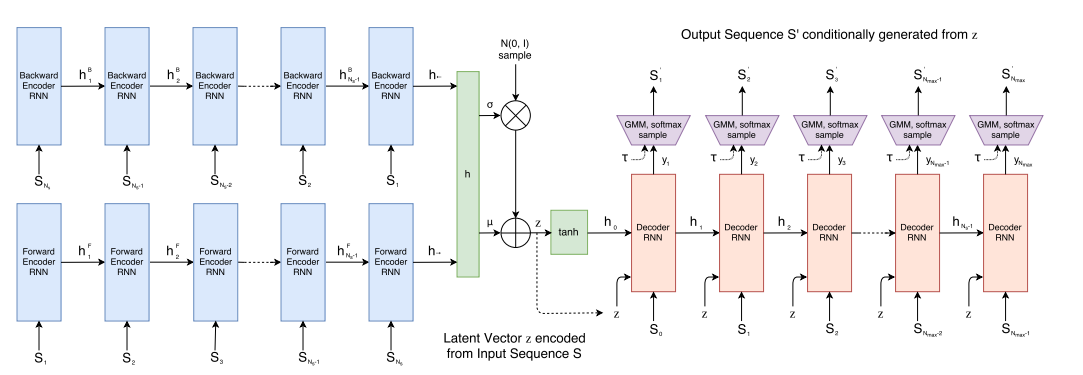

seq --> S
s1 --> (1 X 5) --> batch x dimension (5 --> dx, dy, p1, p2, p3)

encoder:
takes S of size Nmax, so S tensor --> (batch_size X Nmax X 5)

ok so
there is also backward encoding of S (meaning encoding of S reverse)
so encoder_rev will get S_rev
since its encoding we will only get the output h from the last block

so the last block from both encoders will give 2 vectors of size (batch X enc_hsize)

concatonate both vectors to get (batch x 2enc_hsize) tensor --> h

this tensor will go to mu,sigma layer
in this layer we will get mu = W_mu * h + b_mu
and the sig_cap = W_sig * h + b_sig
sigma = exp(sigma_cap / 2)

W_sig, W_mu will be of size (batch X enc_hsize X Nz) 
b_sig, b_mu --> (batch X 1 X Nz)

Where Nz is the encoding dimesion

we will then sample z --> mu + sigma.elem_mult(N(0, 1)) where N(0, 1) is a tensor of size mu/sigma (batch X 1 X Nz) and it is sampled from Normal distribution wiht mean 0 and std = 1

z is the final output of encoder with tensor size of (batch X 1 X Nz)

decoder:
for the decoder the initial h and c (h0 and c0) is initialized by:
z --> tanh(z * Wz + bz) --> z_t
where Wz --> (batch X Nz X 2(dec_hidden_size)) and bz --> (batch X 1 X 2(dec_hidden_size))

h0 --> first half of z_t
c0 --> secound half of z_t

inputs of the decoder will be orignal z concatonated with S_0, S_1 ... S_Nmax
S0 is just the 0 tensor but p1 will be 1 (since pen down) so [0, 0, 1, 0, 0]

so input --> [batch X Nmax X 5 + Nz]
and each cell the input is [batch X 1 X 5 + Nz]

c_i and h_i --> [batch X 1 X dec_hid_size]

output of block:
yi = Wy * h_i + by

where Wy --> [batch X dec_hid_size X 6*M + 3] (where M is the number of normal distribution  for the GMM)

the last 3 values of the yi tensor represents the predicted q1, q2, q3
and the rest of the values are broken into pairs of 6, where the first element is the probablity of the jth bivar-Normal distribtuin and the 5 values along side is the parameters of the bivar-normal distribuion


in the parameters the sig_x and sig_y is passed to the exp function and the pxy is passed to the tanh function

the logits of q1,q2,q3 and Pi(from 1 -> M) is calculated using the softmax.

this gives us the probablity of the pen-state and bivar-normal distribtuion to choose, and from the choosen one we use its parameters to generate the output or sample the output




# Sketch-RNN Architecture Summary

This document outlines the architecture of the Sketch-RNN model, a Sequence-to-Sequence Variational Autoencoder (Seq2Seq VAE) for modeling stroke-based drawings.

## 1. Input Data (`S`)

-   **Format:** Each drawing is represented as a sequence of actions.
-   **Sequence Element:** Each element `S_i` is a 5-dimensional vector: `(Δx, Δy, p1, p2, p3)`
    -   `Δx, Δy`: Relative offset from the previous point.
    -   `p1`: Pen down (stroke continues, `1` if true, `0` otherwise).
    -   `p2`: Pen up (stroke ends, `1` if true, `0` otherwise).
    -   `p3`: End of drawing (`1` if true, `0` otherwise).
    (`p1`, `p2`, `p3` form a one-hot vector).
-   **Tensor Shape:** Input sequences are typically padded to a maximum length `Nmax`. The input tensor shape for a batch is `(batch_size, Nmax, 5)`.

## 2. Encoder

The encoder compresses the input sequence `S` into a probabilistic latent representation `z`.

-   **Bidirectional RNN:**
    -   A forward RNN processes the input sequence `S`.
    -   A backward RNN processes the reversed sequence `S_reverse`.
    -   RNN Type: Typically LSTM or GRU.
    -   Let `enc_hidden_size` be the hidden size of the encoder RNNs.
-   **Context Vector (`h`):**
    -   The final hidden state from the forward RNN (`h_forward`) and the final hidden state from the backward RNN (`h_backward`) are extracted. Both have shape `(batch_size, enc_hidden_size)`.
    -   These are concatenated to form the context vector `h`:
        `h = concat(h_forward, h_backward)`
    -   Shape of `h`: `(batch_size, 2 * enc_hidden_size)`.
-   **VAE Bottleneck (μ and σ Layers):**
    -   Two separate Dense (Linear) layers project `h` to the parameters of the latent distribution. Let `Nz` be the latent dimension size.
    -   **Mean (`μ`):**
        -   `μ = Dense(units=Nz)(h)` (Equivalent to `h @ W_mu + b_mu`)
        -   Shape of `μ`: `(batch_size, Nz)`.
        -   Shape of `W_mu`: `(2 * enc_hidden_size, Nz)`. Shape of `b_mu`: `(Nz,)`.
    -   **Log Variance (`ô`):**
        -   `ô = Dense(units=Nz)(h)` (Equivalent to `h @ W_sig + b_sig`)
        -   Shape of `ô`: `(batch_size, Nz)`.
        -   Shape of `W_sig`: `(2 * enc_hidden_size, Nz)`. Shape of `b_sig`: `(Nz,)`.
    -   **Standard Deviation (`σ`):**
        -   Calculated element-wise: `σ = exp(ô / 2)`
        -   Shape of `σ`: `(batch_size, Nz)`.

## 3. Latent Space (`z`)

-   **Reparameterization Trick:** The latent vector `z` is sampled using the calculated `μ` and `σ`:
    -   Sample `ε` (epsilon) from a standard normal distribution `N(0, I)`. Shape of `ε`: `(batch_size, Nz)`.
    -   `z = μ + σ * ε` (element-wise multiplication)
-   **Shape of `z`:** `(batch_size, Nz)`. This `z` vector represents the compressed "idea" of the input sketch.
-   **KL Divergence Loss (`L_KL`):** Calculated based on `μ` and `ô` (or `σ`) to encourage the distribution of `z` to match the prior `N(0, I)`.

## 4. Decoder

The decoder takes the latent vector `z` and reconstructs/generates the sketch sequence step-by-step.

-   **Initialization:**
    -   The initial hidden state (`h0`) and cell state (`c0`) (for LSTM) of the decoder RNN are derived from `z`.
    -   A Dense layer with `tanh` activation transforms `z`:
        `z_t = tanh(z @ Wz + bz)`
        -   Shape of `Wz`: `(Nz, 2 * dec_hidden_size)`. Shape of `bz`: `(2 * dec_hidden_size,)`.
        -   Shape of `z_t`: `(batch_size, 2 * dec_hidden_size)`.
    -   `h0` takes the first half of `z_t`'s features.
    -   `c0` takes the second half of `z_t`'s features.
    -   Shape of `h0`, `c0`: `(batch_size, dec_hidden_size)`.
-   **Autoregressive Input:**
    -   At each time step `i`, the input `x_i` to the decoder RNN is formed by concatenating the latent vector `z` and the *previous* step's output `S_{i-1}`:
        `x_i = concat(S_{i-1}, z)`
    -   Shape of `x_i`: `(batch_size, 5 + Nz)`.
    -   The sequence starts with a special token `S_0 = [0, 0, 1, 0, 0]`.
-   **Decoder RNN Step:**
    -   The decoder RNN (e.g., LSTM) processes `x_i` and the previous state `(h_{i-1}, c_{i-1})` to produce the new state `(h_i, c_i)`.
    -   `h_i, c_i = DecoderRNN(x_i, state=[h_{i-1}, c_{i-1}])`
    -   Shape of `h_i`, `c_i`: `(batch_size, dec_hidden_size)`.
-   **Output Layer:**
    -   A Dense layer projects the decoder hidden state `h_i` to the raw output parameters `y_i`.
    -   `y_i = h_i @ Wy + by`
    -   Shape of `Wy`: `(dec_hidden_size, 6*M + 3)`. Shape of `by`: `(6*M + 3,)`.
    -   Shape of `y_i`: `(batch_size, 6*M + 3)`. (`M` = number of GMM components).
-   **Output Parameter Interpretation (`y_i` breakdown):**
    -   **Pen State Logits (`q̂`):** The last 3 elements are the logits `(q̂1, q̂2, q̂3)`.
    -   **GMM Parameters:** The first `6*M` elements correspond to the `M` Gaussian components. For each component `j` (from 1 to M):
        -   `Π̂_j`: Logit for the mixture weight.
        -   `μ_{x,j}, μ_{y,j}`: Mean offsets.
        -   `ô_{x,j}, ô_{y,j}`: Log standard deviations.
        -   `ρ̂_{xy,j}`: Unconstrained correlation parameter.
-   **Parameter Transformations & Probabilities:**
    -   **GMM `σ`:** `σ_x = exp(ô_x)`, `σ_y = exp(ô_y)`
    -   **GMM `ρ`:** `ρ_xy = tanh(ρ̂_xy)`
    -   **GMM Weights `Π`:** `Π = softmax([Π̂_1, ..., Π̂_M])`
    -   **Pen States `q`:** `q = softmax([q̂1, q̂2, q̂3])`
-   **Usage:** The calculated probabilities (`Π`, `q`) and constrained GMM parameters (`μ`, `σ`, `ρ`) are used to:
    -   Calculate the Reconstruction Loss (`L_s`, `L_p`) during training.
    -   Sample the next sketch action `S_i = (Δx, Δy, p1, p2, p3)` during generation/inference.